In [13]:
import math
import numpy as np
import sys
import time

#3rd party modules
from astropy.stats import jackknife_stats
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy.constants import c
from astropy.io import fits
import getpass
from halotools.mock_observables import angular_tpcf
from scipy import integrate, interpolate
from scipy.stats import poisson
    
#Plot
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm, ticker, patches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse
## default setting
fig_width_pt = 900                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

def log_10_product(x, pos):
    return '%1g' % (x)

formatter = ticker.FuncFormatter(log_10_product)
%config InlineBackend.figure_format = 'retina'

In [14]:
#Reading in the data

halos = fits.open('MICE2lightcone_halos_Mh13.5above_z0.35.fits')[1].data
print(halos.shape[0])
print(halos['z_cgal_v'])

gws = fits.open('MICE2lightcone_gwhalos_Mh12.5_z0.35.fits')[1].data
print(gws.shape[0])

rand_halos = np.load('MICE2lightcone_rand_halos_Mh13.5above_z0.35.npy')

7804244
[0.16337 0.30527 0.33748 ... 0.16761 0.1341  0.12919]
18041259


In [15]:
#compute luminosity distance versus z_red relation
cp = FlatLambdaCDM(H0=70, Om0=0.25)

numz = 501
a_zred = np.array([iz/numz for iz in range(501)])
a_dL = cp.luminosity_distance(a_zred).value

func_zred_to_dL = interpolate.InterpolatedUnivariateSpline(a_zred, a_dL)
func_dL_to_zred = interpolate.InterpolatedUnivariateSpline(a_dL, a_zred)

In [16]:
zlow = func_dL_to_zred(200)#originally at 1600
zhigh = func_dL_to_zred(400)

#selected in redshift space
mask = (gws['z_cgal_v']>=zlow) & (gws['z_cgal_v']<zhigh)
print('gw {0:4.3f} <= z_red < {1:4.3f}'.format(zlow, zhigh))
print('mean gw z_red = {0:4.3f}'.format(np.mean(gws[mask]['z_cgal_v'])))

tmp_idx = np.random.randint(1, gws[mask].shape[0], size=5100)
tmp_gws = gws[mask][tmp_idx]
print('# of selected gws = {0}'.format(tmp_gws.shape[0]))
#print('# of selected halos = {0}'.format(tmp_halos.shape[0]))

gw 0.045 <= z_red < 0.087
mean gw z_red = 0.080
# of selected gws = 5100


The theta bins: [0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02  0.021 0.022 0.023 0.024
 0.025 0.026 0.027 0.028 0.029 0.03 ]
computation took 55.84342980384827 seconds


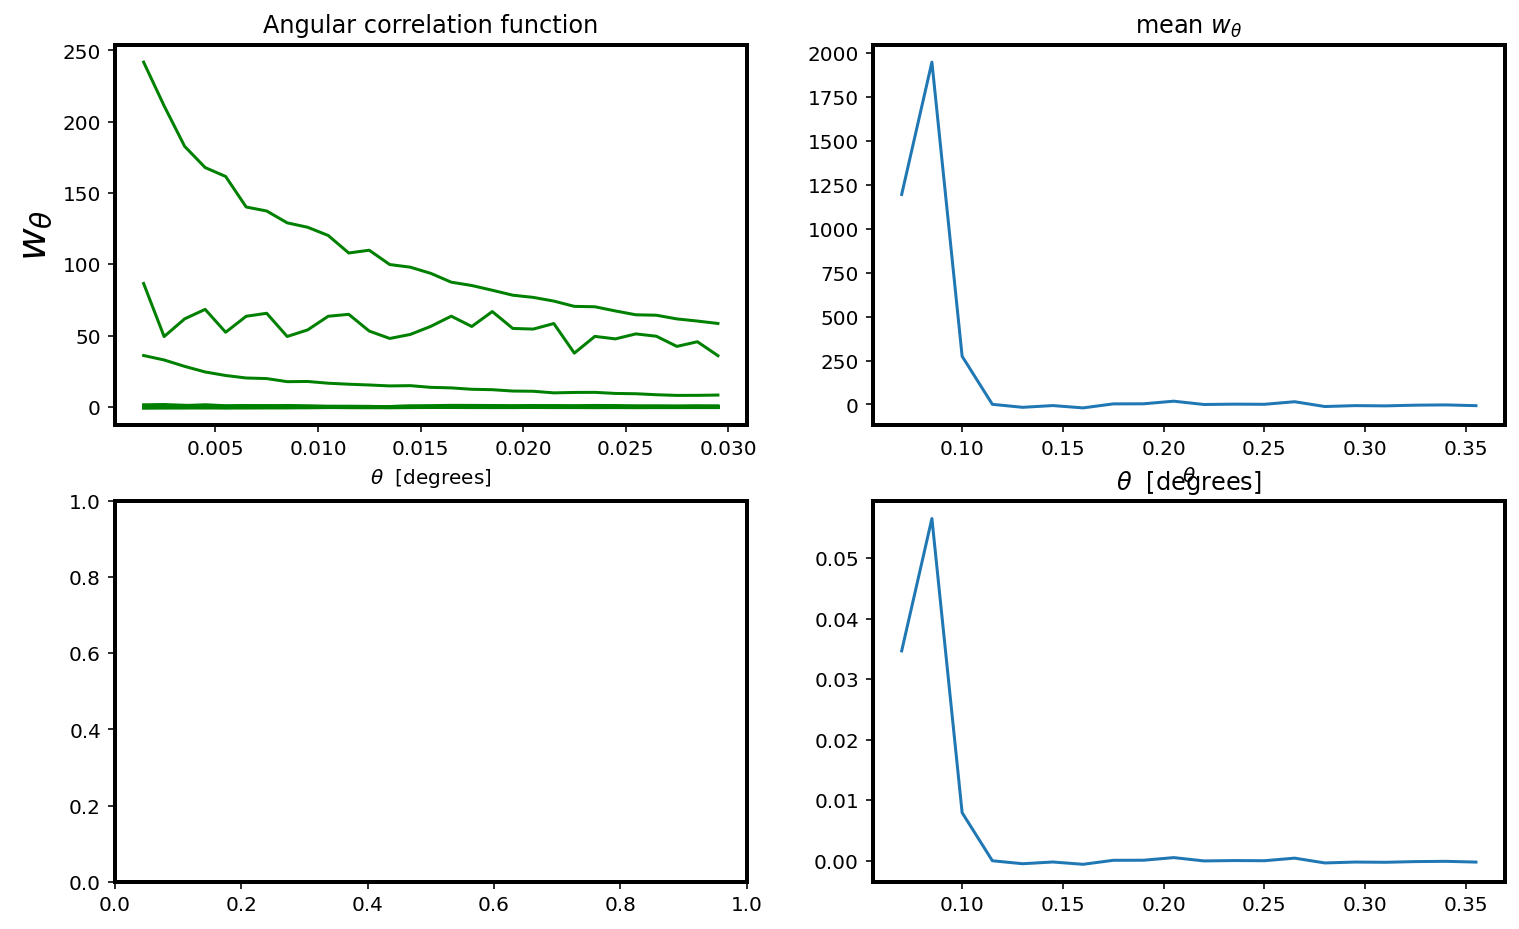

In [22]:
#creating the theta bins for TPCF
theta_bins = np.arange(.001,.031,.001)
cen_theta_bins = (theta_bins[:-1]+theta_bins[1:])/2.0
print("The theta bins:", theta_bins)
#print(theta_bins[0],theta_bins[1])

test_statistic = np.mean

#creating the randoms for the TPCF
def make_random_radec(num_rand):
    dtype_rand = np.dtype([('ra_gal', float), ('dec_gal', float)])
    randoms = np.zeros(shape=(num_rand), dtype=dtype_rand)

    #next assign (ra,dec)
    RA_min, RA_max = 0, np.pi/2 #[radian]pi/2 originally
    DEC_min, DEC_max = 0, np.pi/2 #[radian]pi/2 originally

    ran1_min = RA_min/2/np.pi + 0.5
    ran1_max = RA_max/2/np.pi + 0.5
    ran2_min = 0.5*np.sin(np.pi/2 - DEC_min) + 0.5
    ran2_max = 0.5*np.sin(np.pi/2 - DEC_max) + 0.5

    ran1, ran2 = np.random.random(2*num_rand).reshape(2, -1)
    ran_RA  = (ran1_max - ran1_min)*ran1 + ran1_min
    ran_DEC = (ran2_max - ran2_min)*ran2 + ran2_min #this is actually theta = pi/2 - DEC

    randoms['ra_gal'][:] = 2*np.pi*(ran_RA - 0.5)*180/np.pi #[degree]
    randoms['dec_gal'][:] = np.arcsin(2*(ran_DEC-0.5))*180/np.pi #[degree]
    #print(ran_RA)
    return randoms

rand_gws = make_random_radec(500000)
rand_halos = make_random_radec(500000)
rand_RA2 = rand_gws['ra_gal'][:]
rand_DEC2 = -rand_gws['dec_gal'][:] + 90
rand_N2 = rand_DEC2.shape[0]
rand_ang_coords = np.vstack((rand_RA2,rand_DEC2)).T

tmp_gws = tmp_gws[(tmp_gws['ra_gal']>0) & (tmp_gws['dec_gal']>0)]
RA2 = tmp_gws['ra_gal'][:]
DEC2 = -tmp_gws['dec_gal'][:] + 90
N2 = DEC2.shape[0]

t_s = time.time()
angular_coords2 = np.vstack((RA2,DEC2)).T

mean_y1 = []
mean_x1 = []

fig, axis = plt.subplots(2,2)

for redshift in np.arange(0.07,0.37,0.015):
    halos_mask = (halos['z_cgal_v']>=(redshift-.015)) & (halos['z_cgal_v']<redshift)
    tmp_halos = halos[halos_mask]
    tmp_halos = tmp_halos[(tmp_halos['ra_gal']>0) & (tmp_halos['dec_gal']>0)]
    RA1 = tmp_halos['ra_gal'][:]
    DEC1 = -tmp_halos['dec_gal'][:] + 90
    angular_coords1 = np.vstack((RA1,DEC1)).T
     
    
    ###################### VERY COOL AND GOOD TPCF ####################
    w_theta12 = angular_tpcf(angular_coords1, theta_bins, sample2=angular_coords2, randoms=rand_ang_coords, num_threads='max', do_auto=False, do_cross=True)
    
    ###################### WEIGHTED AVERAGE ###########################
    for n in range(29):
        sum_x = 0
        sum_y = 0
        sum_x += w_theta12[n]
        sum_y += w_theta12[n]*(2*np.pi*theta_bins[n]*(theta_bins[n+1]-theta_bins[n]))
        
    mean_x = sum_x/.03
    mean_y = sum_y/(2*np.pi*theta_bins[29])
    #estimate, bias, stderr, conf_interval = jackknife_stats(w_theta12, test_statistic, 0.95)
    mean_x1.append(mean_x)
    mean_y1.append(mean_y)
    np.vstack(mean_x1)
    np.vstack(mean_y1)
    
    
    ###################### PLOT EVERYTHING ############################
    axis[0,0].plot(cen_theta_bins,w_theta12,'-', color='green',
         label = r'cross_corr')
    axis[0,0].set_ylabel(r'$w_{\theta}$', fontsize=20)
    axis[0,0].set_xlabel(r'$\theta$  $[{\rm degrees}]$')
    axis[0,0].set_title('Angular correlation function')

axis[0,1].plot(np.arange(0.07,0.37,0.015),mean_x1)
axis[0,1].set_title(r'mean $w_{\theta}$')
axis[0,1].set_xlabel('z')
axis[1,1].plot(np.arange(0.07,0.37,0.015),mean_y1)
axis[1,1].set_title(r'mean $\theta$')
axis[0,1].set_xlabel('z')
t_tmp = time.time() - t_s
print('computation took {0} seconds'.format(t_tmp))